# Load data

In [98]:
import pandas as pd

data_fraud = pd.read_csv('../data/data_fraud_final.csv')

In [2]:
data_fraud.head()

,D1,D4,D5,D6,D8,D10,D13,D15,V12,V30,...,M6_nan,M9_T,id_12_NotFound,id_31_chrome 64.0 for android,id_31_chrome generic,id_37_T,DeviceType_mobile,DeviceInfo_SM-A300H Build/LRX22G,DeviceInfo_hi6210sft Build/MRA58K,isFraud
0,14.0,88.931389,29.908723,30.726991,177.131369,13.000000,-5.365878,0.000000,1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,47.168517,56.969919,174.583114,0.000000,2.900229,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,33.781705,34.646134,178.268862,0.000000,-3.856653,315.000000,1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,112.0,94.000000,0.000000,12.142125,181.177056,84.000000,-7.359038,111.000000,1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,245.284719,45.761553,73.034183,136.044491,53.717295,24.006143,53.966745,0.04481,0.306017,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [2]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

data_fraud_sampled = data_fraud.sample(frac=1, random_state=42)

X, y = data_fraud_sampled.drop('isFraud', axis=1), data_fraud_sampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

print('Original train dataset shape {}'.format(Counter(y_train)))
print('Resampled train dataset shape {}'.format(Counter(y_train_res)))
print('Test dataset shape {}'.format(Counter(y_test)))

Original train dataset shape Counter({0.0: 455895, 1.0: 16537})
Resampled train dataset shape Counter({0.0: 455895, 1.0: 455405})
Test dataset shape Counter({0.0: 113982, 1.0: 4126})


# Training

## Without hyperparametrization

In [4]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

dict_models = {}

dict_models['Naive Bayes'] = BernoulliNB()
dict_models['Decision Tree'] = DecisionTreeClassifier(random_state=42)
dict_models['Random Forest'] = RandomForestClassifier(random_state=42, n_estimators=50)
dict_models['Gradient Boosting'] = GradientBoostingClassifier(random_state=42, n_estimators=50)
dict_models['K-NN'] = KNeighborsClassifier()
dict_models['Logistic Regression'] = LogisticRegression(random_state=42, max_iter=500)

In [5]:
from jupyter.utils import model_evaluation_clf
from time import time
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC", "Training Time (s)"])
models = {}
models_res = {}


for i, model_name in enumerate(dict_models.keys()):
    print('Training', model_name, end=' => ')

    model = dict_models[model_name]
    model_res = deepcopy(model)

    start_time = time()
    model.fit(X_train, y_train)
    end_time = time()

    start_time_res = time()
    model_res.fit(X_train_res, y_train_res)
    end_time_res = time()

    models[model_name] = model
    models_res[model_name + ' (res)'] = model_res

    eval = model_evaluation_clf(model, X_test, y_test)
    eval_res = model_evaluation_clf(model_res, X_test, y_test)

    results.loc[2*i] = [model_name, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc'], round(end_time - start_time, 1)]
    results.loc[2*i+1] = [model_name + ' (res)', eval_res['accuracy'], eval_res['precision'], eval_res['recall'], eval_res['f1'], eval_res['roc_auc'], round(end_time_res - start_time_res, 1)]

    print(f"{round(sum([end_time - start_time, end_time_res - start_time_res]), 1)}s")

Training Naive Bayes => 1.0s
Training Decision Tree => 85.0s
Training Random Forest => 293.4s
Training Gradient Boosting => 630.2s
Training K-NN => 0.3s
Training Logistic Regression => 37.4s


In [6]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

                    Model  Accuracy  Precision  Recall  f1-score   AUC  Training Time (s)
      Random Forest (res)     0.991      0.922   0.814     0.865 0.906              185.3
               K-NN (res)     0.945      0.370   0.828     0.512 0.889                0.2
            Decision Tree     0.983      0.756   0.766     0.761 0.878               38.8
      Decision Tree (res)     0.979      0.668   0.769     0.715 0.878               46.2
            Random Forest     0.989      0.966   0.723     0.827 0.861              108.0
  Gradient Boosting (res)     0.920      0.258   0.690     0.375 0.809              454.1
                     K-NN     0.977      0.764   0.493     0.599 0.744                0.1
Logistic Regression (res)     0.783      0.101   0.660     0.176 0.724               25.9
        Naive Bayes (res)     0.751      0.078   0.565     0.137 0.661                0.7
              Naive Bayes     0.759      0.079   0.552     0.138 0.659                0.3
        Gr

## With hyperparametrization

We had better results with the resampled model so for the hyperparametrization we only considered the resampled models.

In [3]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

data_fraud_sampled = data_fraud.sample(frac=1, random_state=42)
nb_col = data_fraud_sampled.shape[1]

X, y = data_fraud_sampled.drop('isFraud', axis=1), data_fraud_sampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

print('Original train dataset shape {}'.format(Counter(y_train)))
print('Resampled train dataset shape {}'.format(Counter(y_train_res)))
print('Test dataset shape {}'.format(Counter(y_test)))

Original train dataset shape Counter({0.0: 455895, 1.0: 16537})
Resampled train dataset shape Counter({0.0: 455895, 1.0: 455405})
Test dataset shape Counter({0.0: 113982, 1.0: 4126})


In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

dict_models = [
    {
        'name_clf' : 'K-NN',
        'model': KNeighborsClassifier(n_neighbors=1),
        'scalers' : [None, MinMaxScaler()],
        'grid' : {},
    },

    {
        'name_clf' : 'Naive Bayes',
        'model': BernoulliNB(),
        'scalers' : [None, MinMaxScaler(), StandardScaler()],
        'grid' : {
            'model__alpha': [10**k for k in range(-5, 6)],
        },
    },

    {
        'name_clf' : 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'scalers' : [None],
        'classifier__max_features': [1, 2, 3],
        'grid' : {
            'model__max_depth': range(1, nb_col + 1),
        },
    },

    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42, n_estimators=50),
        'scalers' : [None],
        'grid' : {
            'model__max_depth': range(1, nb_col + 1, 5),
        },    
    },

    {
        'name_clf' : 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42, n_estimators=50),
        'scalers' : [None],
        'grid' : {
            'model__max_depth': [1, 2, 3],
        },

    },

    {
        'name_clf' : 'Logistic Regression',
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'scalers' : [MinMaxScaler(), StandardScaler()],
        'grid' : {
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
        },
    },
]

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
from jupyter.utils import model_evaluation_clf

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC", "Training Time (s)"])
models = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name = dict_clf['name_clf']
    print(f'Training {model_name}', end=' => ')

    steps = [
        ('scaler', None),
        ('model', dict_clf['model'])
    ]
    pipeline = Pipeline(steps)

    param_grid = {
        'scaler': dict_clf['scalers'],
        **dict_clf['grid']
    }

    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1)

    start_time = time()
    clf.fit(X_train_res, y_train_res)
    end_time = time()
    eval = model_evaluation_clf(clf, X_test, y_test)
    
    models[model_name] = clf
    results.loc[nb_res] = [model_name, eval['accuracy'], eval['precision'], eval['recall'], eval['f1'], eval['roc_auc'], round(end_time - start_time, 1)]
    nb_res += 1

    print(f"{int(end_time - start_time)}s")
    print(clf.best_params_)
    print()

Training K-NN => 1779s
{'scaler': MinMaxScaler()}

Training Naive Bayes => 56s
{'model__alpha': 1e-05, 'scaler': StandardScaler()}

Training Decision Tree => 912s
{'model__max_depth': 28, 'scaler': None}

Training Random Forest => 990s
{'model__max_depth': 31, 'scaler': None}

Training Gradient Boosting => 1006s
{'model__max_depth': 3, 'scaler': None}

Training Logistic Regression => 134s
{'model__C': 10, 'model__penalty': 'l2', 'scaler': StandardScaler()}



In [17]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

              Model  Accuracy  Precision  Recall  f1-score   AUC  Training Time (s)
      Random Forest     0.991      0.914   0.816     0.862 0.906              990.3
      Decision Tree     0.978      0.654   0.774     0.709 0.880              912.1
               K-NN     0.978      0.686   0.679     0.682 0.834             1779.0
  Gradient Boosting     0.920      0.258   0.690     0.375 0.809             1006.3
Logistic Regression     0.850      0.141   0.651     0.232 0.754              134.2
        Naive Bayes     0.757      0.086   0.618     0.151 0.690               56.1


In [18]:
# results.to_csv('../results/results_frac=0.1.csv', index=False)

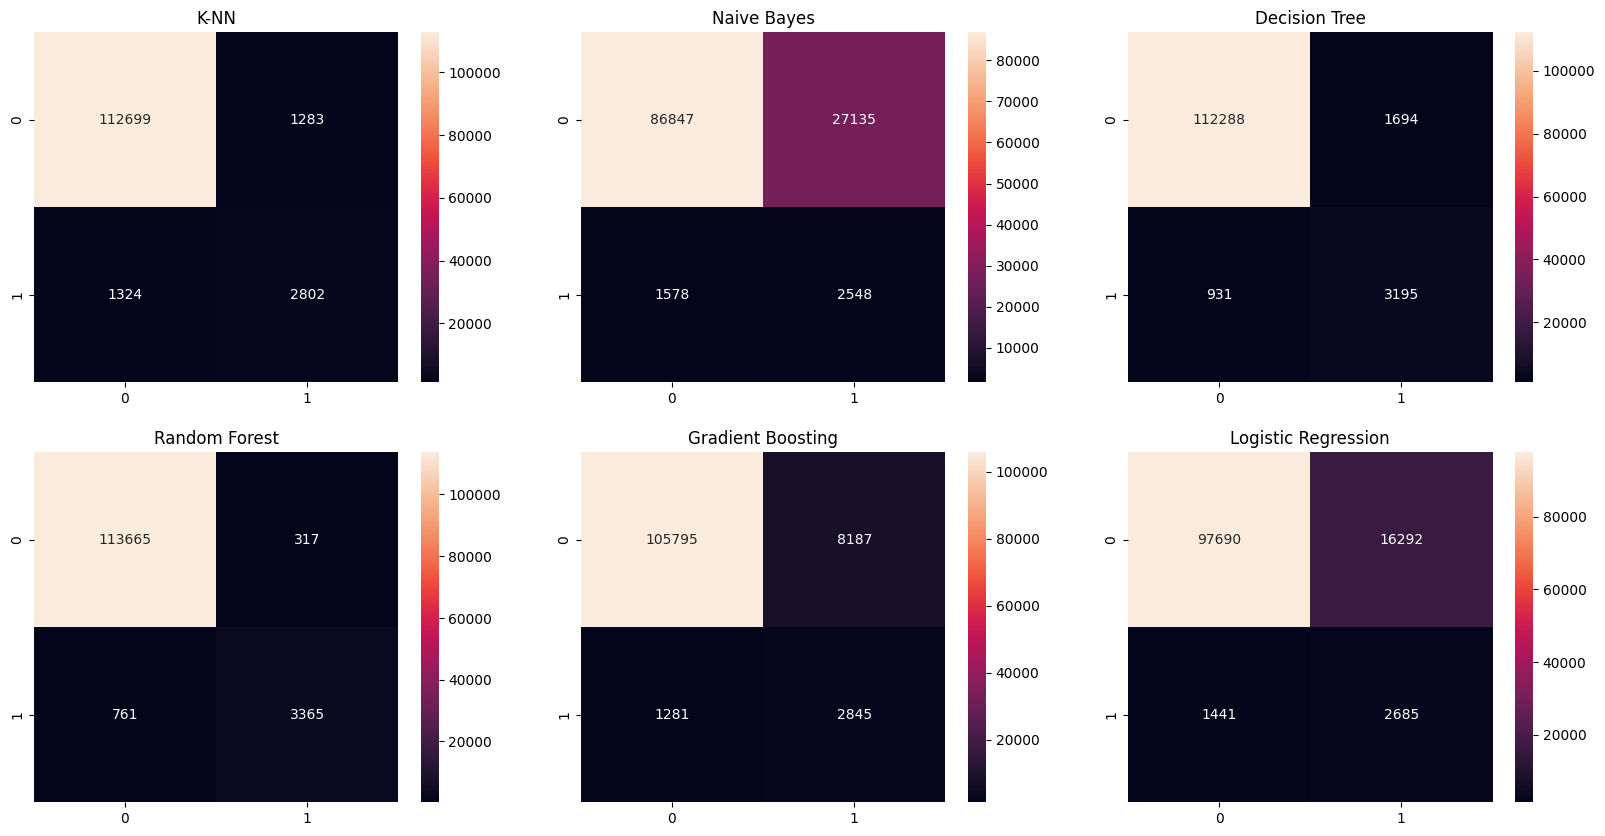

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(model_name)


plt.show()

## Bayes optimization

In [131]:
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

data_fraud_sampled = data_fraud.sample(frac=0.1, random_state=42)
nb_col = data_fraud_sampled.shape[1]

X, y = data_fraud_sampled.drop('isFraud', axis=1), data_fraud_sampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ada = ADASYN(random_state=42)
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

print('Original train dataset shape {}'.format(Counter(y_train)))
print('Resampled train dataset shape {}'.format(Counter(y_train_res)))
print('Test dataset shape {}'.format(Counter(y_test)))

Original train dataset shape Counter({0.0: 45581, 1.0: 1662})
Resampled train dataset shape Counter({0.0: 45581, 1.0: 45358})
Test dataset shape Counter({0.0: 11364, 1.0: 447})


In [132]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

dict_models = [
    {
        'name_clf' : 'K-NN',
        'model': KNeighborsClassifier(),
        'scalers' : {
            'scaler': [MinMaxScaler()],

        },
        'grid' : {
            'model__n_neighbors': [1]
        }
    },

    {
        'name_clf' : 'Naive Bayes',
        'model': BernoulliNB(),
        'scalers' : {
            'scaler' : [None, MinMaxScaler(), StandardScaler()],
        },
        'grid' : {
            'model__alpha': [10**k for k in range(-5, 6)],
        },
    },

    {
        'name_clf' : 'Logistic Regression',
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'scalers' : {
            'scaler': [StandardScaler()],
        },
        'grid' : {
            'model__C': [0.1, 1, 10],
            # 'model__penalty': ['l1', 'l2'],
            'model__penalty': ['l2'],
        },
    },

    {
        'name_clf' : 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'scalers' : {
            'scaler': [None],
        },
        'classifier__max_features': [1, 2, 3],
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1)),
        },
    },

    {
        'name_clf' : 'Random Forest',
        'model': RandomForestClassifier(random_state=42, n_estimators=50),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': list(range(1, nb_col + 1, 5)),
        },    
    },

    {
        'name_clf' : 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42, n_estimators=50),
        'scalers' : {
            'scaler': [None],
        },
        'grid' : {
            'model__max_depth': [1, 2, 3],
        },

    },

]

In [133]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from time import time
from jupyter.utils import model_evaluation_clf
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "f1-score", "AUC", "Training Time (s)"])
models_bayes = {}
models_gs = {}
nb_res = 0

for i, dict_clf in enumerate(dict_models):
    model_name_gs = dict_clf['name_clf']
    model_name_bayes = model_name_gs + ' (Bayes)'
    print(f'Training {model_name_gs}', end=' => ')

    model = dict_clf['model']

    steps_gs = [
        ('scaler', None) if dict_clf['scalers'] is not None else 'passthrough',
        ('model', model)
    ]
    steps_bayes = [
        ('scaler', None) if dict_clf['scalers'] is not None else 'passthrough',
        ('model', deepcopy(model))
    ]
    pipeline_gs = Pipeline(steps_gs)
    pipeline_bayes = Pipeline(steps_bayes)

    param_grid = {
        **dict_clf['scalers'],
        **dict_clf['grid']
    }

    clf_bayes = BayesSearchCV(pipeline_bayes, search_spaces=param_grid, cv=2, n_jobs=-1, n_iter=10)
    clf_gs = GridSearchCV(pipeline_gs, param_grid=param_grid, cv=2, n_jobs=-1)

    start_time_bayes = time()
    clf_bayes.fit(X_train_res, y_train_res)
    end_time_bayes = time()

    start_time_gs = time()
    clf_gs.fit(X_train_res, y_train_res)
    end_time_gs = time()
    
    print(clf_gs.best_params_)
    print(clf_bayes.best_params_)

    eval_gs = model_evaluation_clf(clf_gs, X_test, y_test)
    eval_bayes = model_evaluation_clf(clf_bayes, X_test, y_test)
    
    models_bayes[model_name_bayes] = clf_bayes
    models[model_name_gs] = clf_gs

    results.loc[nb_res] = [model_name_gs, eval_gs['accuracy'], eval_gs['precision'], eval_gs['recall'], eval_gs['f1'], eval_gs['roc_auc'], round(end_time_gs - start_time_gs, 1)]
    results.loc[nb_res+1] = [model_name_bayes, eval_bayes['accuracy'], eval_bayes['precision'], eval_bayes['recall'], eval_bayes['f1'], eval_bayes['roc_auc'], round(end_time_bayes - start_time_bayes, 1)]
    nb_res += 2

    # print(f"{int(end_time - start_time)}s")
    # print(clf_gs.best_params_)
    # print(clf_bayes.best_params_)
    print()

Training K-NN => 

{'model__n_neighbors': 1, 'scaler': MinMaxScaler()}
OrderedDict([('model__n_neighbors', 1), ('scaler', MinMaxScaler())])

Training Naive Bayes => 

KeyboardInterrupt: 

In [ ]:
results = results.sort_values(by='AUC', ascending=False)
print(results.to_string(index=False))

                      Model  Accuracy  Precision  Recall  f1-score   AUC  Training Time (s)
        Logistic Regression     0.842      0.152   0.696     0.250 0.772                3.1
Logistic Regression (Bayes)     0.841      0.152   0.696     0.249 0.771                6.9
